In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import time

%matplotlib inline

In [2]:
df = pd.read_csv('C:/Users/vivek/Downloads/global-commodity-trade-statistics/commodity_trade_statistics_data.csv')

C:\Users\vivek\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
df.head()

,country_or_area,year,comm_code,commodity,flow,trade_usd,weight_kg,quantity_name,quantity,category
0,Afghanistan,2016,10410,"Sheep, live",Export,6088,2339.0,Number of items,51.0,01_live_animals
1,Afghanistan,2016,10420,"Goats, live",Export,3958,984.0,Number of items,53.0,01_live_animals
2,Afghanistan,2008,10210,"Bovine animals, live pure-bred breeding",Import,1026804,272.0,Number of items,3769.0,01_live_animals
3,Albania,2016,10290,"Bovine animals, live, except pure-bred breeding",Import,2414533,1114023.0,Number of items,6853.0,01_live_animals
4,Albania,2016,10392,"Swine, live except pure-bred breeding > 50 kg",Import,14265937,9484953.0,Number of items,96040.0,01_live_animals


In [4]:
df.shape

(8225871, 10)

## EDA

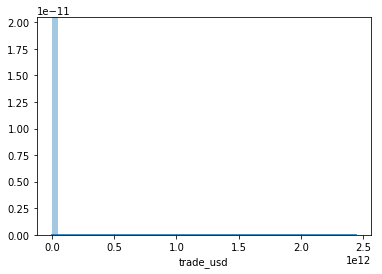

In [5]:
sns.distplot(df['trade_usd'])

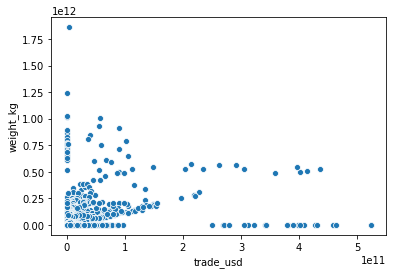

In [6]:
sns.scatterplot(df['trade_usd'], df['weight_kg'])

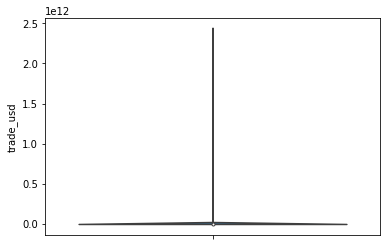

In [7]:
sns.violinplot(y=df['trade_usd'])

In [9]:
df['year'].value_counts()

2006    378177
2012    377526
2011    374784
2007    374492
2009    374126
2010    373977
2013    371122
2005    369366
2014    364636
2008    363777
2004    362432
2015    359240
2003    358746
2001    347685
2002    346480
2000    346067
1999    309716
1998    291643
2016    289653
1997    281103
1996    252395
1995    233399
1994    198220
1993    154742
1992    121214
1991     83951
1990     72272
1989     63933
1988     30997
Name: year, dtype: int64

In [10]:
df['country_or_area'].value_counts()

Australia                           307627
Canada                              216293
Argentina                           201738
Brazil                              184830
Austria                             180838
China, Hong Kong SAR                172466
China                               156585
Belgium                             141331
Bulgaria                            130405
Algeria                             125009
Denmark                             122602
Belarus                             119572
Chile                               117306
France                              111695
Barbados                            109293
Czech Rep.                          107004
Colombia                            104430
Finland                             104204
Albania                             103792
Bahrain                             102430
Bahamas                             102332
Cyprus                              101994
Bangladesh                          101230
Croatia    

In [11]:
df['commodity'].value_counts()

ALL COMMODITIES                                                            9185
Food preparations nes                                                      8048
Sugar confectionery not chewing gum, no cocoa content                      7764
Sauces nes, mixed condiments, mixed seasoning                              7693
Cigarettes containing tobacco                                              7620
Communion wafers, rice paper, bakers wares nes                             7530
Hats and other headgear, knit or crochet, nes                              7450
Cargo containers designed for carriage                                     7434
Sweet biscuits, waffles and wafers                                         7402
Paintings/drawings/pastels executed by hand                                7358
Glues or adhesives, prepared nes, package > 1kg                            7345
Chocolate/cocoa food preparations nes                                      7267
Refined sugar, in solid form, nes, pure 

In [12]:
df['comm_code'].value_counts()

TOTAL     9185
210690    8048
170490    7764
210390    7693
240220    7620
190590    7530
650590    7450
860900    7434
190530    7402
350699    7345
180690    7267
170199    7258
230990    7242
880330    7222
650610    7207
350610    7064
210110    7043
100630    7039
210410    7030
890399    7025
210320    7006
170410    6981
650699    6972
190410    6960
10600     6940
190190    6872
350691    6872
190219    6860
660199    6824
190230    6777
          ... 
720831      60
721729      60
293970      59
721733      58
846110      57
282737      55
720934      53
440332      52
721723      52
291817      52
480791      51
840130      51
900721      49
721111      48
842850      48
721341      48
850620      40
720841      39
844841      38
284810      38
847040      37
291441      37
290316      36
283693      28
283521      28
843062      25
290521      18
846929      10
846939      10
720140      10
Name: comm_code, Length: 5047, dtype: int64

In [13]:
df['quantity_name'].value_counts()

Weight in kilograms                                 6617980
Number of items                                      709321
No Quantity                                          505176
Volume in litres                                     144599
Area in square metres                                135912
Number of pairs                                       67929
Length in metres                                      18225
Volume in cubic meters                                17775
Weight in carats                                       5237
Thousands of items                                     1386
Electrical energy in thousands of kilowatt-hours       1264
Number of packages                                     1067
Name: quantity_name, dtype: int64

In [14]:
pd.get_dummies(df['category'])

,01_live_animals,02_meat_and_edible_meat_offal,03_fish_crustaceans_molluscs_aquatic_invertebrates_ne,04_dairy_products_eggs_honey_edible_animal_product_nes,05_products_of_animal_origin_nes,06_live_trees_plants_bulbs_roots_cut_flowers_etc,07_edible_vegetables_and_certain_roots_and_tubers,08_edible_fruit_nuts_peel_of_citrus_fruit_melons,09_coffee_tea_mate_and_spices,10_cereals,...,90_optical_photo_technical_medical_etc_apparatus,91_clocks_and_watches_and_parts_thereof,92_musical_instruments_parts_and_accessories,93_arms_and_ammunition_parts_and_accessories_thereof,94_furniture_lighting_signs_prefabricated_buildings,95_toys_games_sports_requisites,96_miscellaneous_manufactured_articles,97_works_of_art_collectors_pieces_and_antiques,99_commodities_not_specified_according_to_kind,all_commodities
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Feature Selection

In [15]:
df=df.dropna()

In [16]:
new_df = pd.concat([df, pd.get_dummies(df['flow']), pd.get_dummies(df['category']), pd.get_dummies(df['quantity_name'])], axis=1)

In [17]:
new_df.head()

,country_or_area,year,comm_code,commodity,flow,trade_usd,weight_kg,quantity_name,quantity,category,...,Length in metres,No Quantity,Number of items,Number of packages,Number of pairs,Thousands of items,Volume in cubic meters,Volume in litres,Weight in carats,Weight in kilograms
0,Afghanistan,2016,10410,"Sheep, live",Export,6088,2339.0,Number of items,51.0,01_live_animals,...,0,0,1,0,0,0,0,0,0,0
1,Afghanistan,2016,10420,"Goats, live",Export,3958,984.0,Number of items,53.0,01_live_animals,...,0,0,1,0,0,0,0,0,0,0
2,Afghanistan,2008,10210,"Bovine animals, live pure-bred breeding",Import,1026804,272.0,Number of items,3769.0,01_live_animals,...,0,0,1,0,0,0,0,0,0,0
3,Albania,2016,10290,"Bovine animals, live, except pure-bred breeding",Import,2414533,1114023.0,Number of items,6853.0,01_live_animals,...,0,0,1,0,0,0,0,0,0,0
4,Albania,2016,10392,"Swine, live except pure-bred breeding > 50 kg",Import,14265937,9484953.0,Number of items,96040.0,01_live_animals,...,0,0,1,0,0,0,0,0,0,0


In [18]:
new_df = new_df.drop(['country_or_area', 'commodity', 'flow', 'quantity_name', 'category'], 1)

In [19]:
new_df.head()

,year,comm_code,trade_usd,weight_kg,quantity,Export,Import,Re-Export,Re-Import,01_live_animals,...,Length in metres,No Quantity,Number of items,Number of packages,Number of pairs,Thousands of items,Volume in cubic meters,Volume in litres,Weight in carats,Weight in kilograms
0,2016,10410,6088,2339.0,51.0,1,0,0,0,1,...,0,0,1,0,0,0,0,0,0,0
1,2016,10420,3958,984.0,53.0,1,0,0,0,1,...,0,0,1,0,0,0,0,0,0,0
2,2008,10210,1026804,272.0,3769.0,0,1,0,0,1,...,0,0,1,0,0,0,0,0,0,0
3,2016,10290,2414533,1114023.0,6853.0,0,1,0,0,1,...,0,0,1,0,0,0,0,0,0,0
4,2016,10392,14265937,9484953.0,96040.0,0,1,0,0,1,...,0,0,1,0,0,0,0,0,0,0


In [20]:
new_df.dtypes

year                                                        int64
comm_code                                                  object
trade_usd                                                   int64
weight_kg                                                 float64
quantity                                                  float64
Export                                                      uint8
Import                                                      uint8
Re-Export                                                   uint8
Re-Import                                                   uint8
01_live_animals                                             uint8
02_meat_and_edible_meat_offal                               uint8
03_fish_crustaceans_molluscs_aquatic_invertebrates_ne       uint8
04_dairy_products_eggs_honey_edible_animal_product_nes      uint8
05_products_of_animal_origin_nes                            uint8
06_live_trees_plants_bulbs_roots_cut_flowers_etc            uint8
07_edible_

In [21]:
new_df = new_df[new_df['comm_code'] != '9999AA']
new_df = new_df[new_df['comm_code'] != 'TOTAL']

In [22]:
new_df['comm_code'] = new_df['comm_code'].astype('int64')

In [23]:
X = new_df.drop('trade_usd', 1)
Y = new_df['trade_usd']

In [24]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y)

In [ ]:
select = SelectKBest(k=100)
select.fit(X_test, Y_test)
X = select.tranform(X_test)

In [ ]:
rfr = RandomForestRegressor(n_estimators=10, max_depth=3)
rfr.fit(X_test, Y_test)
print("Test data score: ", rfr.score(X_test, Y_test))

In [25]:
pca = PCA(n_components=100)
pca.fit(X_train, Y_train)

PCA(copy=True, iterated_power='auto', n_components=100, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [26]:
x_pca = pca.transform(X_train)

In [27]:
x_test_pca = pca.transform(X_test)

## Random Forest

In [28]:
start = time.time()
rfr = RandomForestRegressor(n_estimators=10, max_depth=3)
rfr.fit(x_pca, Y_train)
end = time.time()
print("Time taken: ", end-start)
print("Train data score: ", rfr.score(x_pca, Y_train))

Time taken:  1437.1980731487274
Train data score:  0.6191739545773198


In [29]:
print("Test data score: ", rfr.score(x_test_pca, Y_test))

Test data score:  0.6488299098116391


In [30]:
x_pca.shape

(5905760, 100)

## Gradient Boosting

In [31]:
start = time.time()
gbr = GradientBoostingRegressor(n_estimators=10)
gbr.fit(x_pca, Y_train)
end = time.time()
print("Time taken: ", end-start)
print("Train data score: ", gbr.score(x_pca, Y_train))
print("Test data score: ", gbr.score(x_test_pca, Y_test))

Time taken:  2283.686767578125
Train data score:  0.5841035235112342
Test data score:  0.6112534513727557


## 2nd Approach

In [32]:
def convertToInteger(x, y):
    temp={}
    for i, val in enumerate(df[x].unique()):
        temp[val] = i+1
    for j in temp:
        df.at[df[x]==j, y] = temp[j]

In [33]:
df.columns

Index(['country_or_area', 'year', 'comm_code', 'commodity', 'flow',
       'trade_usd', 'weight_kg', 'quantity_name', 'quantity', 'category'],
      dtype='object')

In [34]:
convertToInteger('country_or_area', 'country')
convertToInteger('flow', 'flow2')
convertToInteger('quantity_name', 'scale')
convertToInteger('category', 'categ')

In [35]:
df.columns

Index(['country_or_area', 'year', 'comm_code', 'commodity', 'flow',
       'trade_usd', 'weight_kg', 'quantity_name', 'quantity', 'category',
       'country', 'flow2', 'scale', 'categ'],
      dtype='object')

In [37]:
new_df = df.drop(['country_or_area', 'commodity', 'flow', 'quantity_name', 'category'], 1)

In [38]:
new_df = new_df[new_df['comm_code'] != '9999AA']
new_df = new_df[new_df['comm_code'] != 'TOTAL']

In [39]:
new_df['comm_code'] = new_df['comm_code'].astype('int64')

In [41]:
X = new_df.drop('trade_usd', 1)
Y = new_df['trade_usd']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y)

In [45]:
pca = PCA(n_components=8)
pca.fit(X_train, Y_train)
x_pca = pca.transform(X_train)
x_test_pca = pca.transform(X_test)

In [50]:
start = time.time()
rfr = RandomForestRegressor(n_estimators=10, max_depth=3)
param_grid = {
    'n_estimators': [20, 30, 40],
    'max_features': ['auto', 'sqrt']
}
CV_rfr = GridSearchCV(rfr, param_grid=param_grid, cv=3)
CV_rfr.fit(x_pca, Y_train)
end = time.time()
print("Time taken: ", end-start)
print("Train data score: ", CV_rfr.score(x_pca, Y_train))
print("Test data score: ", CV_rfr.score(x_test_pca, Y_test))
print(x_pca.shape)

Time taken:  7704.702841281891
Train data score:  0.6094275817181158
Test data score:  0.46530275191969084
(5905760, 8)


In [51]:
print("Best Parameters: ", CV_rfr.best_params_)

Best Parameters:  {'max_features': 'auto', 'n_estimators': 40}


In [47]:
start = time.time()
gbr = GradientBoostingRegressor(n_estimators=10)
gbr.fit(x_pca,  Y_train)
end = time.time()
print("Time taken: ", end-start)
print("Train data score: ", gbr.score(x_pca, Y_train))
print("Test data score: ", gbr.score(x_test_pca, Y_test))

Time taken:  254.02960681915283
Train data score:  0.5349543233662761
Test data score:  0.45765428978379447
